# Bulk Synchronous Parallel
Bulk Synchronous Parallel (BSP, z. Dt. *massensynchrone Parallelrechner*) ist sein sehr einfaches Modell für parallele Programmierung, das zunächst zu Beginn der 90er eingeführt wurde, um die Entwicklung und auch Analyse paralleler Algorithmen zu vereinfachen.

In [ ]:
from tui_dsmt.parallel import mpi_run

## Inhaltsverzeichnis
- [BSP Computer](#BSP-Computer)
- [Algorithmus](#Algorithmus)
- [Kostenanalyse](#Kostenanalyse)
- [Implementierung mit MPI](#Implementierung-mit-MPI)
- [Zusammenfassung](#Zusammenfassung)

## BSP Computer
Dem Modell liegt die Idee eines Computers zugrunde, der einige Eigenschaften erfüllen muss. Computer ist dabei nicht im engeren Sinne zu verstehen, sondern kann beispielsweise auch mehrere, durch ein Netzwerk verbundene Einzelcomputer bezeichnen.
- Der Computer besteht aus einer Reihe von Prozessoren, die jeweils einen eigenen Speicher besitzen. (Das können auch isolierte Prozesse sein, die auf mehreren Kernen ausgeführt werden. Der direkte Zugriff ist aber nur auf den eigenen, lokalen Speicher möglich.)
- Ein *Router* kann Nachrichten zwischen zwei beliebigen Komponenten verteilen.
- Der lokale Speicher ist deutlich schneller angebunden als entfernter Speicher.
- Die Arbeit des Netzwerks wird als Black Box betrachtet.
- Ein globaler Synchronisationsmechanismus wird benötigt. (Gewünscht ist das Verhalten einer Barriere, an der jeder Prozessor wartet, bis sie von allen Prozessoren erreicht wurde.)

## Algorithmus
Der BSP Algorithmus ist in sogenannte Supersteps unterteilt. Diese dienen zur Organisation der Aufgaben und bestehen immer aus drei Teilen:
1. Während der **lokalen Berechnung** führt jede Prozessor-Einheit unabhängig von den anderen Berechnungen auf ihren lokalen Daten aus.
2. Während der **Kommunikation** tauschen die Prozessoren Daten untereinander aus.
3. Während der **Synchronisation** wartet jeder Prozess, bis alle Prozesse die Kommunikationsphase abgeschlossen haben.

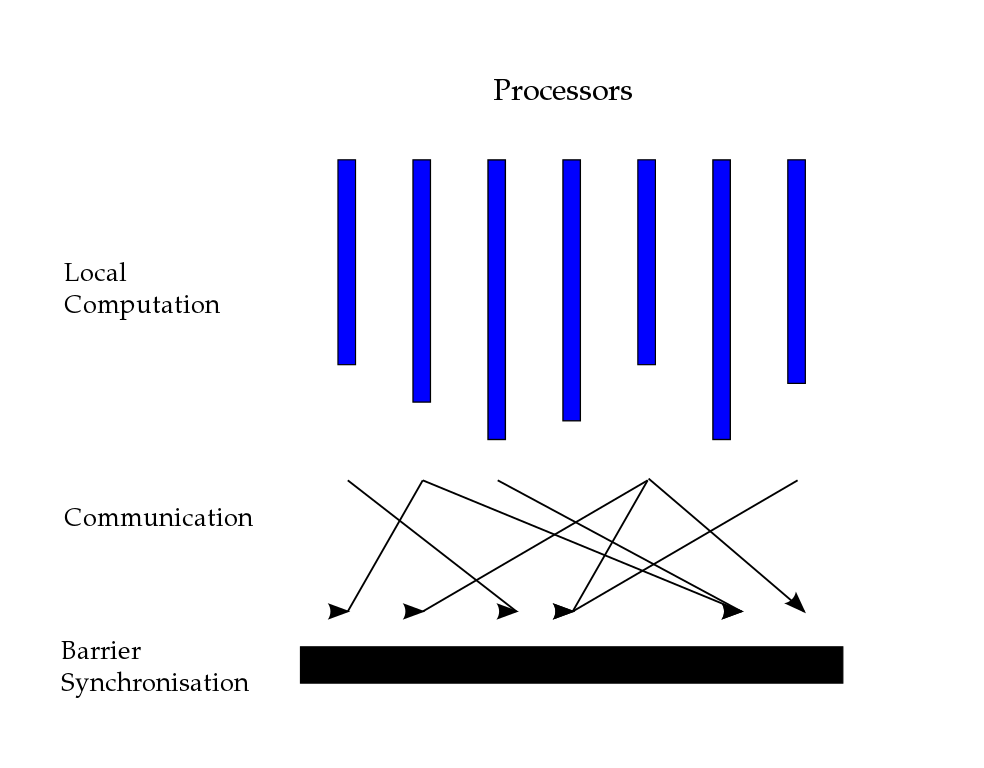

Dieser Ablauf verspricht eine klar strukturierte Programmierung und vermeidet durch globale Synchronisationspunkte übliche Fehler der parallelen Programmierung. Die Kommunikation ist ebenfalls einfach implementierbar. Das Modell birgt jedoch auch einige Nachteile:
- Algorithmen, bei denen die benötigten Daten für einen Schritt nicht immer im Voraus offensichtlich sind, muss auch die Kommunikation innerhalb der Berechnung erlaubt werden. Sogenannte *Mixed Supersteps* besitzen daher keine Trennung zwischen der Berechnungs- und Kommunikationsphase, erlauben aber auch mehr Fehler.
- Das Warten auf die Synchronisation kann bei Teilproblemen ungleicher Größe dafür sorgen, dass Prozessoren lange Zeit auf das Ergebnis anderer warten, was die Effizienz senkt. Adaptive Techniken können helfen, dieses Problem zu umgehen, erhöhen aber wiederum den Implementierungsaufwand.

Die Anzahl der Supersteps ist nicht begrenzt.

## Kostenanalyse
Da BSP nicht nur als Vorschlag zur Implementierung dienen, sondern auch die Anaylse vereinfachen sollte, wird zudem ein Kostenmodell vorgeschlagen.

Die notwendige Zeit für den Berechnungsschritt bestimmt sich durch das Maximum der Zeiten, welche die Prozessoren für die Abarbeitung der ihr zugewiesenen Aufgaben benötigen. Diese wiederum wird durch die Geschwindigkeit des einzelnen Prozessors und die Größe der Aufgabe festgelegt. Für das Senden und Empfangen wird Vollduplex angenommen, sodass die Zeit durch die Größe der zu sendenden Daten und die Bandbreite des Routers definiert wird. (Die Originalarbeit macht keinen Unterschied zwischen einer langen und mehreren kurzen Nachrichten mit der gleichen Gesamtlänge. Zudem nahegelegt, von einer ausreichend großen Menge an Daten auszugehen und die Bandbreite zu unterschätzen, sodass die Latenz der Übertragung ignoriert werden kann.) Den letzten Anteil besitzt die Synchronisationszeit, die vom langsamte Prozessor vorgegeben wird, da alle anderen darauf warten müssen, dass eben dieser den Synchronisationsschritt abschließt.

Eine der wichtigsten Schlussfolgerungen aus dieser Kostenbetrachtung ist damit, dass mit einer steigenden Anzahl beteiligter Prozessoren auch die Kommunikation schneller werden muss, da sonst kein Speedup zu erwarten ist. Dem Autor nach müssen die Netzwerkkapazitäten schneller wachsen als die Berechnungskapazitäten.

## Implementierung mit MPI
Beispielhaft ist nachfolgend eine optimierungsbedürftige Variante der Mittelwert- und Varianzberechnung dargestellt. Dazu wird eine Unterteilung in drei Supersteps vorgenommen:
1. Prozess $0$ erzeugt ein zufälliges Array.
2. Die Prozesse berechnen für ihren Teil des Arrays die lokale Summe.
3. Die Gesamtsumme wird aus den Teilsummen bestimmt, um die Varianz zu berechnen.

In [ ]:
def mpi_fun():
    import mpi4py
    import numpy as np

    comm = MPI.COMM_WORLD
    rank, size = comm.Get_rank(), comm.Get_size()

    # Berechnung 0: Erzeugung eines zufälligen Arrays
    nums = None
    if rank == 0:
        nums = np.random.random(10_000_000)

    # Kommunikation 0
    if rank == 0:
        for i in range(1, size):
            comm.send(nums, dest=i)
    else:
        nums = comm.recv(source=0)

    # Synchronisation 0
    comm.Barrier()

    # Berechnung 1: lokale Summe
    start_index, end_index = (len(nums) // size * rank, len(nums) // 3 * (rank+1))
    if rank == size - 1:
        end_index = len(nums)

    my_nums = nums[start_index:end_index]
    my_sum = sum(my_nums)

    # Kommunikation 1
    all_sums = [comm.bcast(my_sum, root=i) for i in range(size)]

    # Synchronisation 1
    comm.Barrier()

    # Berechnung 2: lokale Summe der quadratischen Abweichung
    mean = sum(all_sums) / len(nums)
    my_sqr_diff = sum((my_nums - mean) ** 2)

    # Kommunikation 2
    all_sqr_diffs = [comm.bcast(my_sqr_diff, root=i) for i in range(size)]

    # Synchronisation 2
    comm.Barrier()

    # Berechnung der Varianz
    var = sum(all_sqr_diffs) / len(nums)
    return mean, var

mpi_run(mpi_fun)

## Zusammenfassung
Das BSP-Modell ist ein aus Paradigma zur Entwicklung paralleler Algorithmen, welche dazu in Supersteps mit immer drei Komponenten eingeteilt werden. Die strikte Unterteilung soll die Programmierung vereinfachen und insbesondere häufige Fehler bei der Programmierung paralleler Programme vermeiden. Das BSP-Modell ist außerdem Grundlage für weitere Algorithmen, die effizient bestimmte Daten verarbeiten.